In [1]:
import dataset_utils as dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#column_names = ['ID', 
#                'INPUT_1', 'INPUT_2', 'INPUT_3', 'INPUT_4', 'INPUT_5', 'INPUT_6', 'INPUT_7', 'INPUT_8', 'INPUT_9', 'INPUT_10',
#                'TARGET_x', 'TARGET_y', 'TARGET_z']
#dataframe = pd.read_csv("../data/ML-CUP23-TR.csv", sep=',', comment='#', names=column_names, index_col= 'ID')
#dataframe.head()

In [3]:
train_loaders, val_loaders = dataset.load_train_dataset(
    "../data/ML-CUP23-TR.csv", folds=2, batch_size=100)

Fold 1
Fold 2


In [4]:
import torch as t
import mlp

# Define the loss function
loss_fn = t.nn.MSELoss()

train_loss = []  # List to store losses for plotting
test_loss = []  # List to store losses for plotting

In [5]:
lr = 0.01
momentum = 0.75
decay = 0.0
nesterov = True
epochs = 50

In [6]:
# build Neural Network with torch
model = mlp.MLP()
optimizer = t.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=decay, nesterov=nesterov)

Fold: 1
Train Epoch: 0 [4/5 Loss: 790.6908935546875
Train Epoch: 1 [4/5 Loss: 780.8811767578125
Train Epoch: 2 [4/5 Loss: 778.0674438476562
Train Epoch: 3 [4/5 Loss: 777.03671875
Train Epoch: 4 [4/5 Loss: 776.3632446289063
Train Epoch: 5 [4/5 Loss: 775.8983764648438
Train Epoch: 6 [4/5 Loss: 775.6365966796875
Train Epoch: 7 [4/5 Loss: 775.4952880859375
Train Epoch: 8 [4/5 Loss: 775.4033081054688
Train Epoch: 9 [4/5 Loss: 775.3381591796875
Train Epoch: 10 [4/5 Loss: 775.2849853515625
Train Epoch: 11 [4/5 Loss: 775.2444702148438
Train Epoch: 12 [4/5 Loss: 775.2096557617188
Train Epoch: 13 [4/5 Loss: 775.18046875
Train Epoch: 14 [4/5 Loss: 775.1562622070312
Train Epoch: 15 [4/5 Loss: 775.1348022460937
Train Epoch: 16 [4/5 Loss: 775.1168090820313
Train Epoch: 17 [4/5 Loss: 775.1000122070312
Train Epoch: 18 [4/5 Loss: 775.0853515625
Train Epoch: 19 [4/5 Loss: 775.0723754882813
Train Epoch: 20 [4/5 Loss: 775.0604736328125
Train Epoch: 21 [4/5 Loss: 775.0504272460937
Train Epoch: 22 [4/5 Loss

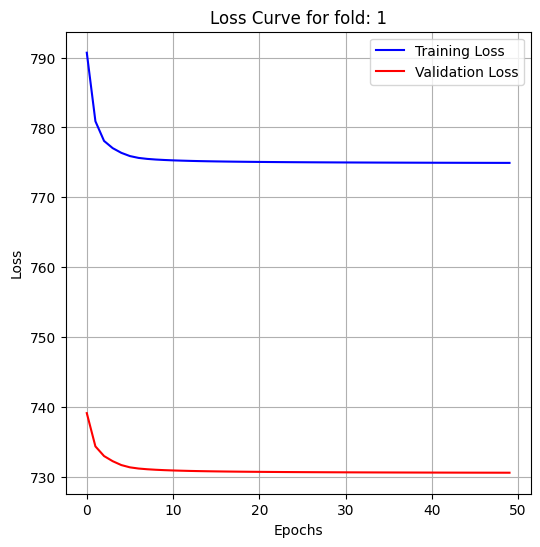

Fold: 2
Train Epoch: 0 [4/5 Loss: 730.5774658203125
Train Epoch: 1 [4/5 Loss: 730.5746459960938
Train Epoch: 2 [4/5 Loss: 730.5723510742188
Train Epoch: 3 [4/5 Loss: 730.5704711914062
Train Epoch: 4 [4/5 Loss: 730.5686401367187
Train Epoch: 5 [4/5 Loss: 730.5668701171875
Train Epoch: 6 [4/5 Loss: 730.5652099609375
Train Epoch: 7 [4/5 Loss: 730.5638916015625
Train Epoch: 8 [4/5 Loss: 730.5622436523438
Train Epoch: 9 [4/5 Loss: 730.5607788085938
Train Epoch: 10 [4/5 Loss: 730.559375
Train Epoch: 11 [4/5 Loss: 730.5581665039062
Train Epoch: 12 [4/5 Loss: 730.5568237304688
Train Epoch: 13 [4/5 Loss: 730.5556274414063
Train Epoch: 14 [4/5 Loss: 730.5542602539062
Train Epoch: 15 [4/5 Loss: 730.553173828125
Train Epoch: 16 [4/5 Loss: 730.5520263671875
Train Epoch: 17 [4/5 Loss: 730.5508911132813
Train Epoch: 18 [4/5 Loss: 730.5498901367188
Train Epoch: 19 [4/5 Loss: 730.5488525390625
Train Epoch: 20 [4/5 Loss: 730.54794921875
Train Epoch: 21 [4/5 Loss: 730.5467529296875
Train Epoch: 22 [4/5 L

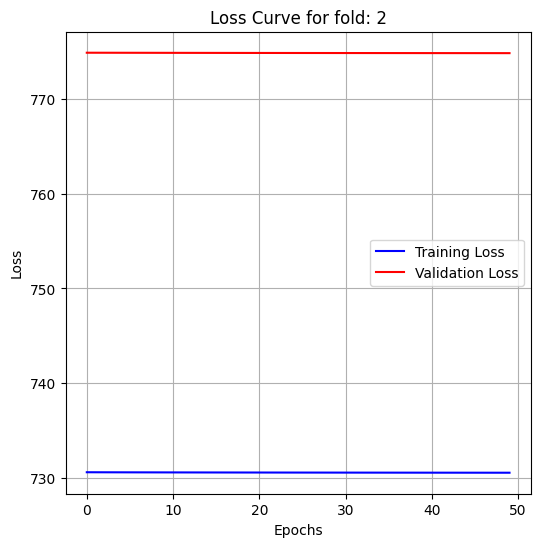

In [7]:
fold = 0
for train_loader, val_loader in zip(train_loaders, val_loaders):
    fold += 1
    mlp.train(model, train_loader, fold, loss_fn=loss_fn, optimizer=optimizer, val_data=val_loader, epochs=epochs)